In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


Connecting celiib@10.28.0.34:3306


In [4]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
pinky_nda = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


In [5]:
synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation
segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = soma & "cell_class='excitatory'"

In [6]:
"""
WHERE THE RF CORRELATION BINS ARE EXPLICITELY SET
"""

attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.25'

cbin_edges = np.linspace(-.7, .7, 6) #setting the bin boundaries
#calculates the centers of the bins used for the receptive field
cbin_centers = np.hstack((np.nan, np.round((cbin_edges[1:] + cbin_edges[:-1])/2, decimals=2), np.nan))
#creates labels for the receptive field edges
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(cbin_edges[:-1], cbin_edges[1:])]
cbin_labels

['[-0.7,-0.4]', '[-0.4,-0.1]', '[-0.1,0.1]', '[0.1,0.4]', '[0.4,0.7]']

In [7]:
"""
Calculate the bins and centers for the orientational preference
"""
#defines how to find the "tuned" segments of the orientation
dori_resolution = np.pi / 2 / 4 #setting the width size of the bins to be 22.5 degrees
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9) #creates 8 bins between boundaries between 0 and pi

# turns all of the bin edges into degrees with no decimal
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in bin_edges]])
#creates the bin boundary markings with [low - high]
bin_labels = list(zip(be[:-1], be[1:]))

#calculates the bin centers
bin_centers = np.round((bin_edges[1:] + bin_edges[:-1])/2 * rad2deg, decimals=2) 

In [8]:
"""
Gets the segments with the acceptable rf thresholds
"""

# functional metrics for each functional soma pair (restricting by spattune fitting significance)

sig_units_rf = spattune.BestSTA.Loc & 'sta_snr > 1.25' & segment
sig_unit_pairs_rf = (sig_units_rf.proj(segment_id1 = 'segment_id') * 
                  sig_units_rf.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

sig_units_rf
# attrs_rf = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
# spatconn_df_rf = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs_rf) * fc.SharedInput.proj(*attrs_rf, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())
# spatconn_df_rf

segmentation segmentation id,stabestfit_method method index,segment_id segment id unique within each Segmentation,sta_hash unique hash for combination of sta analysis methods,offset background amplitude,amp peak amplitude,center_x peak center x coordinate (pixels),center_y peak center y coordinate (pixels),sigma_x peak x standard deviation (pixels),sigma_y peak y standard deviation (pixels),theta 2D gaussian rotation (radians),sta_snr signal noise ratio (ROI variance / background std),shuff_snr median signal noise ratio (mean(abs(ROI)) / background std) of shuffled fits,snr_pvalue p value of sta snr by reshuffle
3,1,648518346341355048,e79ed922e65f9890f689729a81d3cfbe,5.62047e-05,0.000217698,86.0,56.0,10.0,10.0,1e-10,1.554,0.968487,0.1
3,1,648518346341355275,b1dcab04cbffc7c60d803a6d84098fbb,7.58462e-05,0.000396789,85.9904,51.987,12.508,10.8278,0.60951,1.33516,0.98395,0.1
3,1,648518346341360400,3f0ca2c7c9cc2d6399474ea597166be3,6.99573e-05,0.000432397,84.0,52.0,10.0,10.0,1e-10,1.57787,0.973847,0.1
3,1,648518346341361901,10f9af8f0608e50f8e8396b0e7fceb67,5.42023e-05,0.000165743,81.5911,56.0244,15.4846,11.5083,0.475382,1.29768,0.971844,0.1
3,1,648518346341366913,b7a191fac5a9ce85d6257f222515cc3f,6.04211e-05,0.000635907,91.3585,46.7473,10.9637,10.3841,0.270319,1.76615,0.975451,0.1
3,1,648518346341367107,1c15ba3fbf5378c195b38f40587eea64,5.74829e-05,0.000192614,87.4386,47.8696,10.7329,10.9388,3.75996e-41,1.25175,1.07395,0.1
3,1,648518346341367466,c8fbd00b9e43bd018469fd3c3a560ca1,6.54275e-05,0.000616503,89.1197,47.8727,12.1583,10.9825,0.606826,1.57832,0.949603,0.1
3,1,648518346341368307,56c482e17892e922787472838c961987,6.40173e-05,0.000412995,90.0,53.0,10.0,10.0,1e-10,1.49112,0.955084,0.1
3,1,648518346341368824,dceef117863906a6280affc489cfa2d1,7.47788e-05,0.000512626,91.0,49.0,10.0,10.0,1e-10,1.52648,1.03388,0.1
3,1,648518346341373381,9a52b47e029fb7c68d0e857e7ebde0ab,4.79191e-05,0.000281922,92.0,52.0,10.0,10.0,1e-10,1.35962,1.00238,0.1


In [9]:
"""
Was just checking that the SharedInput table had around enough entries
"""
# targets = (pinky.Segment & pinky_nda.Trace & "segmentation=3") - pinky.SegmentExclude
# print(len(targets))
# info = targets * targets.proj(segment_b='segment_id') & 'segment_id < segment_b'
# info

# # but then the total combination gets further restricted by those that have synapses

'\nWas just checking that the SharedInput table had around enough entries\n'

In [10]:
"""gets table where have every connection from segment_a to segment b anf the number of n_seg_shared stacked on a 
repeat but the ids for a and b are switched  """
shi = fc.SharedInput.proj("n_seg_shared",segment_a="segment_id")
shi

segmentation segmentation id,segment_a segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments
3,648518346341353058,648518346341353574,0
3,648518346341353058,648518346341353607,0
3,648518346341353058,648518346341354313,0
3,648518346341353058,648518346341354496,0
3,648518346341353058,648518346341355048,0
3,648518346341353058,648518346341355198,0
3,648518346341353058,648518346341355275,0
3,648518346341353058,648518346341355736,1
3,648518346341353058,648518346341356241,0
3,648518346341353058,648518346341356256,3


In [11]:
#check that have neurons from both orphans and excitatory
len(shi & pinky.Decimation35Orphan.proj(segment_a="segment_id")),len(shi & pinky.PymeshfixDecimatedExcitatoryStitchedMesh.proj(segment_a="segment_id"))

(301239, 12214)

In [12]:
rf_table = (spattune.BestSTACorr.proj(rf_corr_coef="union_corr_r2",
                          segment_a="segment_id1",segment_b="segment_id2")
                          & sig_units_rf.proj(segment_a="segment_id") &
                          sig_units_rf.proj(segment_b="segment_id"))
rf_table

sta_hash1 unique hash for combination of sta analysis methods,sta_hash2 unique hash for combination of sta analysis methods,apert_radius radius of imposed circular aperture (pixels),segmentation segmentation id,segment_a segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,rf_corr_coef r2 pearson correlation btw pixels in either roi
0065baf936a265c861c7ff427a6d612b,02892ccd6609ef16ff85eb2bbd0fc76d,20,3,648518346348459615,648518346349475518,-0.244465
0065baf936a265c861c7ff427a6d612b,0c9690706ee3325ab0922419658f3d61,20,3,648518346348459615,648518346349471565,0.0728065
0065baf936a265c861c7ff427a6d612b,0fbb7b57ca25964a4a17af3a7dd2b9b3,20,3,648518346348459615,648518346349505261,-0.253615
0065baf936a265c861c7ff427a6d612b,1149e81487b2d2b4a79e705cb4468369,20,3,648518346348459615,648518346349498286,0.326714
0065baf936a265c861c7ff427a6d612b,17ea71d568dd7cd012a06fcdffd13164,20,3,648518346348459615,648518346349511321,-0.256014
0065baf936a265c861c7ff427a6d612b,19458def4aa48c0b33d79cfb5612ae08,20,3,648518346348459615,648518346349509112,0.163773
0065baf936a265c861c7ff427a6d612b,1e7b56e426ee303269b0aa7ad5b238e4,20,3,648518346348459615,648518346349507092,0.258669
0065baf936a265c861c7ff427a6d612b,21ee5042c3cad99aafe3c0640f5c8ccb,20,3,648518346348459615,648518346349505250,-0.0440386
0065baf936a265c861c7ff427a6d612b,223756265c6e267c251a713ae419e6bc,20,3,648518346348459615,648518346349507537,0.835593
0065baf936a265c861c7ff427a6d612b,2d864015bac8888476db44ff3373a8d6,20,3,648518346348459615,648518346349508447,0.307406


In [13]:
# #old way that didn't account for tuning
# rf_table = spattune.BestSTACorr.proj(rf_corr_coef="union_corr_r2",
#                           segment_a="segment_id1",segment_b="segment_id2",
#                          )
# rf_table

In [14]:
# (radtune.BestVonCorr() & sig_units_op.proj(segment_id1="segment_id") & sig_units_op.proj(segment_id2="segment_id")).proj("diff_pref_ori")

In [15]:
"""
build the pref_rel table to use for the orinetation data

This table just needs the 
1) segment_id
2) von_r2 (orientation preference)
--> for all of the tuned segments
"""
tuned = 'confidence > 0.5'
#get the significantly tuned segments
sig_units_op = radtune.BestVonFit.Unit & 'von_p_value <= 0.05' & tuned & segment
sig_units_op
# sig_unit_pairs_op = (sig_units_op.proj(segment_id1 = 'segment_id') * 
#                  sig_units_op.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'


#gets the significantly tuned neurons and their differences in combinational pairs 
sig_unit_pairs_op = (radtune.BestVonCorr() & sig_units_op.proj(segment_id1="segment_id") 
                 & sig_units_op.proj(segment_id2="segment_id")).proj("diff_pref_ori")

sig_unit_pairs_op = sig_unit_pairs_op.proj(segment_a="segment_id1",
                                           segment_b="segment_id2",
                                           dori="diff_pref_ori")
sig_unit_pairs_op


von_hash1 unique hash for combination of sta analysis methods,von_hash2 unique hash for combination of sta analysis methods,segmentation segmentation id,segment_a segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,dori difference in preferred orientation (radians)
43e78ae3adb467d09adcde611f01448b,c534715cb303f36303087976793c693e,3,648518346341352081,648518346341353574,-0.217894
43e78ae3adb467d09adcde611f01448b,66dc6420ca132a85ddda25939f084caa,3,648518346341352081,648518346341356241,-1.25001
c534715cb303f36303087976793c693e,66dc6420ca132a85ddda25939f084caa,3,648518346341353574,648518346341356241,-1.03212
43e78ae3adb467d09adcde611f01448b,73dbecb8885beae030be3c263406f897,3,648518346341352081,648518346341356256,1.43801
66dc6420ca132a85ddda25939f084caa,73dbecb8885beae030be3c263406f897,3,648518346341356241,648518346341356256,-0.453565
c534715cb303f36303087976793c693e,73dbecb8885beae030be3c263406f897,3,648518346341353574,648518346341356256,-1.48569
43e78ae3adb467d09adcde611f01448b,3413479df9a1e7fb1b81bb8219beb975,3,648518346341352081,648518346341357933,1.38358
66dc6420ca132a85ddda25939f084caa,3413479df9a1e7fb1b81bb8219beb975,3,648518346341356241,648518346341357933,-0.507999
73dbecb8885beae030be3c263406f897,3413479df9a1e7fb1b81bb8219beb975,3,648518346341356256,648518346341357933,-0.0544344
c534715cb303f36303087976793c693e,3413479df9a1e7fb1b81bb8219beb975,3,648518346341353574,648518346341357933,-1.54012


# Where to filter only according to those pairs that have signifcant number of shared segments in terms of those semgnets that are similarly contacted

In [16]:
#this is all the possible combination of segments without being limited at all by the number of synapses
fc.ContactCorrelation.proj("n_seg_shared") 

segmentation segmentation id,segment_id segment id unique within each Segmentation,segment_b id of the postsynaptic neuron,n_seg_shared n_presyns contacting onto both segment_id and segment_b
3,648518346341353058,648518346341353574,0
3,648518346341353058,648518346341353607,27
3,648518346341353058,648518346341353788,0
3,648518346341353058,648518346341354313,0
3,648518346341353058,648518346341354496,8
3,648518346341353058,648518346341355048,78
3,648518346341353058,648518346341355198,0
3,648518346341353058,648518346341355736,134
3,648518346341353058,648518346341356241,0
3,648518346341353058,648518346341356256,579


In [17]:
len(fc.SharedInput())

314028

In [18]:
significant_contacts = 100
#sig_cont= dict(n_seg_shared=significant_contacts)
sign_contact_correlations = fc.ContactCorrelation.proj("n_seg_shared") & "n_seg_shared>"+ str(significant_contacts)
sign_contact_correlations

segmentation segmentation id,segment_id segment id unique within each Segmentation,segment_b id of the postsynaptic neuron,n_seg_shared n_presyns contacting onto both segment_id and segment_b
3,648518346341353058,648518346341355736,134
3,648518346341353058,648518346341356256,579
3,648518346341353058,648518346341357933,355
3,648518346341353058,648518346341359123,436
3,648518346341353058,648518346341361018,167
3,648518346341353058,648518346341361981,198
3,648518346341353058,648518346341362995,384
3,648518346341353058,648518346341366161,379
3,648518346341353058,648518346341366757,712
3,648518346341353058,648518346341367133,173


In [19]:
len(shi),len(shi & sign_contact_correlations.proj(segment_a="segment_id"))
new_shi = shi & sign_contact_correlations.proj(segment_a="segment_id")

In [20]:
""" takes all of the possible shared input combinations:
1) gets this correlation table and renames seg a and b and uses that to restrict the shared input combinations and attach the rf correlation
2) Further restricts to only those TUNED with prefered orientation (and adds on the orientation for a and b)
3) Restrict to only significant rective fields for both segment A and B by DOES NOT ATTACH THE RF score

"""

crel = shi * rf_table * sig_unit_pairs_op
new_crel =  new_shi * rf_table * sig_unit_pairs_op
len(crel),len(new_crel)

(3081, 1486)

In [21]:
crel = new_crel

In [22]:
cdf = pd.DataFrame(crel.fetch())

In [23]:
cbin_centers

array([  nan, -0.56, -0.28, -0.  ,  0.28,  0.56,   nan])

In [24]:
# #Test to see if the binning makes a difference


# #check that would still get the same bins
# union_edges = np.linspace(min(cdf['rf_corr_coef']), max(cdf['rf_corr_coef']), 6)
# ue = list(['{:.2f}'.format(ee) for ee in union_edges])
# union_labels = list(zip(ue[:-1], ue[1:]))
# union_centers = np.hstack((np.nan, np.round((union_edges[1:] + union_edges[:-1])/2, decimals=2), np.nan))

# cbin_edges = union_edges
# cbin_centers=union_centers
# cbin_labels = union_labels

In [25]:
#gets the bins of the correlations of the receptive fields
cdf['bcorr'] = cbin_centers[(np.digitize(cdf['rf_corr_coef'], cbin_edges))]
#makes the number of shared segments as floats
cdf['n_seg_shared'] = np.array(cdf['n_seg_shared']).astype(float)
#makes the bins of the corelation of the receptive fields as floats
cdf['bcorr'] = np.array(cdf['bcorr']).astype(float)
cdf

,segmentation,segment_a,segment_b,sta_hash1,sta_hash2,apert_radius,von_hash1,von_hash2,n_seg_shared,rf_corr_coef,dori,bcorr
0,3,648518346341366913,648518346349471565,b7a191fac5a9ce85d6257f222515cc3f,0c9690706ee3325ab0922419658f3d61,20,44474bbe7b563dc5dee23b57fddb34e9,ea7d60f34fe148d38a772c45ffd9d8d2,0.0,-0.000473,-0.197077,-0.00
1,3,648518346341366913,648518346349491953,b7a191fac5a9ce85d6257f222515cc3f,78eac735b763d65c41768fee6b4ae6ce,20,44474bbe7b563dc5dee23b57fddb34e9,38bf00d354e6cafde363b0f174946c0d,3.0,-0.485549,-0.472809,-0.56
2,3,648518346341366913,648518346349493653,b7a191fac5a9ce85d6257f222515cc3f,73ab60252d0e18998faf21a46886a395,20,44474bbe7b563dc5dee23b57fddb34e9,c58b95168e713f24be6938c707e03493,1.0,0.144929,0.152055,0.28
3,3,648518346341366913,648518346349498286,b7a191fac5a9ce85d6257f222515cc3f,1149e81487b2d2b4a79e705cb4468369,20,44474bbe7b563dc5dee23b57fddb34e9,f9078c122c2fe1b57c88ce8f6396d146,0.0,-0.524252,-1.300420,-0.56
4,3,648518346341366913,648518346349498482,b7a191fac5a9ce85d6257f222515cc3f,c5a6de7d3ea65f005197b4a028ed019a,20,44474bbe7b563dc5dee23b57fddb34e9,ef8a969303c6494f7c496c5789d6a66b,1.0,0.116521,-0.432571,-0.00
5,3,648518346341366913,648518346349499085,b7a191fac5a9ce85d6257f222515cc3f,34a7238e90a8f1fa366d93b4a6309b45,20,44474bbe7b563dc5dee23b57fddb34e9,49ac3d385cc310c3b98173bff4e7f648,0.0,0.381318,0.047653,0.28
6,3,648518346341366913,648518346349500440,b7a191fac5a9ce85d6257f222515cc3f,a2982a8f8c4ad879354c815bc3cfe90b,20,44474bbe7b563dc5dee23b57fddb34e9,3af9bc1d06c34e01855aeb403bed1784,2.0,0.039351,0.416990,-0.00
7,3,648518346341366913,648518346349501481,b7a191fac5a9ce85d6257f222515cc3f,4d2730880f177300ab07fcd9e2dda0d9,20,44474bbe7b563dc5dee23b57fddb34e9,e9eec3371ab8620c7144e009f559f326,1.0,0.435481,-0.135157,0.56
8,3,648518346341366913,648518346349504618,b7a191fac5a9ce85d6257f222515cc3f,37fcda78e6df88560d2a062ada1166f0,20,44474bbe7b563dc5dee23b57fddb34e9,27a564db9433239ddbc95b233e217c8a,1.0,0.077164,-0.306546,-0.00
9,3,648518346341366913,648518346349505061,b7a191fac5a9ce85d6257f222515cc3f,ef16aa16cb3c4149adec7386fe273070,20,44474bbe7b563dc5dee23b57fddb34e9,843e6c4187319a2b99600807f69df485,0.0,0.679048,0.579675,0.56


In [26]:
np.abs(cdf["dori"])

0       0.197077
1       0.472809
2       0.152055
3       1.300420
4       0.432571
          ...   
1481    0.044026
1482    1.068060
1483    0.764857
1484    1.352700
1485    1.024030
Name: dori, Length: 1486, dtype: float64

In [27]:
cbin_edges

array([-0.7 , -0.42, -0.14,  0.14,  0.42,  0.7 ])

In [28]:
cbin_centers

array([  nan, -0.56, -0.28, -0.  ,  0.28,  0.56,   nan])

In [29]:
cdf['bdori'] = bin_centers[(np.digitize(np.abs(cdf["dori"]), bin_edges))-1]
cdf

,segmentation,segment_a,segment_b,sta_hash1,sta_hash2,apert_radius,von_hash1,von_hash2,n_seg_shared,rf_corr_coef,dori,bcorr,bdori
0,3,648518346341366913,648518346349471565,b7a191fac5a9ce85d6257f222515cc3f,0c9690706ee3325ab0922419658f3d61,20,44474bbe7b563dc5dee23b57fddb34e9,ea7d60f34fe148d38a772c45ffd9d8d2,0.0,-0.000473,-0.197077,-0.00,11.25
1,3,648518346341366913,648518346349491953,b7a191fac5a9ce85d6257f222515cc3f,78eac735b763d65c41768fee6b4ae6ce,20,44474bbe7b563dc5dee23b57fddb34e9,38bf00d354e6cafde363b0f174946c0d,3.0,-0.485549,-0.472809,-0.56,33.75
2,3,648518346341366913,648518346349493653,b7a191fac5a9ce85d6257f222515cc3f,73ab60252d0e18998faf21a46886a395,20,44474bbe7b563dc5dee23b57fddb34e9,c58b95168e713f24be6938c707e03493,1.0,0.144929,0.152055,0.28,11.25
3,3,648518346341366913,648518346349498286,b7a191fac5a9ce85d6257f222515cc3f,1149e81487b2d2b4a79e705cb4468369,20,44474bbe7b563dc5dee23b57fddb34e9,f9078c122c2fe1b57c88ce8f6396d146,0.0,-0.524252,-1.300420,-0.56,78.75
4,3,648518346341366913,648518346349498482,b7a191fac5a9ce85d6257f222515cc3f,c5a6de7d3ea65f005197b4a028ed019a,20,44474bbe7b563dc5dee23b57fddb34e9,ef8a969303c6494f7c496c5789d6a66b,1.0,0.116521,-0.432571,-0.00,33.75
5,3,648518346341366913,648518346349499085,b7a191fac5a9ce85d6257f222515cc3f,34a7238e90a8f1fa366d93b4a6309b45,20,44474bbe7b563dc5dee23b57fddb34e9,49ac3d385cc310c3b98173bff4e7f648,0.0,0.381318,0.047653,0.28,11.25
6,3,648518346341366913,648518346349500440,b7a191fac5a9ce85d6257f222515cc3f,a2982a8f8c4ad879354c815bc3cfe90b,20,44474bbe7b563dc5dee23b57fddb34e9,3af9bc1d06c34e01855aeb403bed1784,2.0,0.039351,0.416990,-0.00,33.75
7,3,648518346341366913,648518346349501481,b7a191fac5a9ce85d6257f222515cc3f,4d2730880f177300ab07fcd9e2dda0d9,20,44474bbe7b563dc5dee23b57fddb34e9,e9eec3371ab8620c7144e009f559f326,1.0,0.435481,-0.135157,0.56,11.25
8,3,648518346341366913,648518346349504618,b7a191fac5a9ce85d6257f222515cc3f,37fcda78e6df88560d2a062ada1166f0,20,44474bbe7b563dc5dee23b57fddb34e9,27a564db9433239ddbc95b233e217c8a,1.0,0.077164,-0.306546,-0.00,11.25
9,3,648518346341366913,648518346349505061,b7a191fac5a9ce85d6257f222515cc3f,ef16aa16cb3c4149adec7386fe273070,20,44474bbe7b563dc5dee23b57fddb34e9,843e6c4187319a2b99600807f69df485,0.0,0.679048,0.579675,0.56,33.75


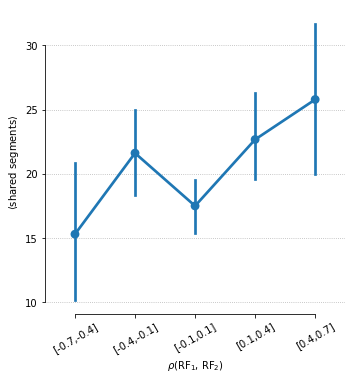

In [30]:
"""
Plots 3 different ones of where compares n_seg_shared (y) vs. binned correlation of the receptive field
"""
g = sns.catplot('bcorr', 'n_seg_shared', data=cdf, kind='point', legend_out=True, sharey=False)
g.set_axis_labels(x_var=r'$\rho$(RF$_1$, RF$_2$)', y_var=r'$\langle$shared segments$\rangle$')

for ax in g.axes.ravel():
    ax.yaxis.grid(True, linestyle=':')
    ax.set_xticklabels(cbin_labels, rotation=30)
sns.despine(trim=True)
g.set_titles('{col_name} axons')

g.fig.savefig('figures/average_shared_input_vs_correlation.png', dpi=200)
g.fig.savefig('figures/average_shared_input_vs_correlation.pdf')

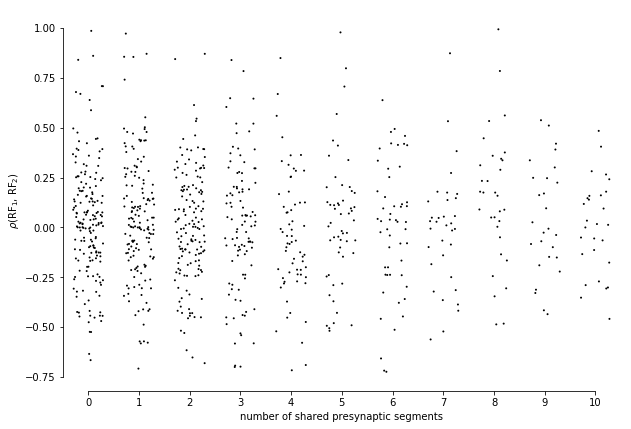

In [31]:
"""
Strip plot is a way of grouping data and ploting them along a continuous value 
- jitter just helps spread out the data points

Conclusion what it graphs:
1) Takes all of the data with number of shared segments less than 11 
and plots the rf correlation coefficiet for those groups

"""
g = sns.stripplot( 'n_seg_shared', 'rf_corr_coef', data=cdf[cdf.n_seg_shared < 11], jitter=0.3, s=2, color='k')
g.set_xlabel(r'number of shared presynaptic segments')
g.set_xticklabels([int(e) for e in g.get_xticks()])
g.set_ylabel(r'$\rho$(RF$_1$, RF$_2$)')
sns.despine(trim=True)
g.figure.set_size_inches((10,7))
g.figure.savefig('figures/shared_input_stripplot.png', dpi=200)
g.figure.savefig('figures/shared_input_stripplot.pdf')

In [32]:
"""
Exploring how to make equal depth bins with two categories (could do one iteratively or analysis)
Goal: have a nxn array that has equal numbers in all (or as close to equal numbers)

Algorithm: 
1) Try starting by finding the quartiles of each of the groups and then bin the data according to that
"""

#getting the data values
rf_correlation = cdf["rf_corr_coef"].values
ori_difference = cdf["dori"].values
ori_difference

ori_bin_edges = [np.min(np.abs(ori_difference)),
     np.percentile(np.abs(ori_difference),25),
     np.percentile(np.abs(ori_difference),50),
     np.percentile(np.abs(ori_difference),75),
     np.max(np.abs(ori_difference))]
#get the midpoints of each
ori_bin_midpoints = np.round([np.mean(ori_bin_edges[i:i+2]) for i in range(0,len(ori_bin_edges)-1)],2)
ori_bin_midpoints_angles = np.round((ori_bin_midpoints)*180/np.pi,2)
print(ori_bin_edges)
print(ori_bin_midpoints_angles)

rf_bin_edges = [np.min(rf_correlation),
     np.percentile(rf_correlation,25),
     np.percentile(rf_correlation,50),
     np.percentile(rf_correlation,75),
     np.max(rf_correlation)]

rf_bin_midpoints = np.round([np.mean(rf_bin_edges[i:i+2]) for i in range(0,len(rf_bin_edges)-1)],2)
print(rf_bin_edges)
print(rf_bin_midpoints)


#now add new columns that bin the groups according to thsoe edges
cdf["bcorr_2"] = rf_bin_midpoints[np.digitize(cdf["rf_corr_coef"].values,rf_bin_edges,right=True)-1]
cdf["bdori_2"] = ori_bin_midpoints_angles[np.digitize(np.abs(cdf["dori"].values),ori_bin_edges,right=True)-1]


[2.21994e-05, 0.28668025, 0.6239429999999999, 1.01252, 1.57078]
[ 8.02 26.36 46.98 73.91]
[-0.72451, -0.167275, 0.02878205, 0.21390325, 0.993803]
[-0.45 -0.07  0.12  0.6 ]


In [33]:
#lets see what the cound value is 
cdf.groupby(["bcorr_2","bdori_2"])["n_seg_shared"].count()

bcorr_2  bdori_2
-0.45    8.02        86
         26.36       99
         46.98       97
         73.91       89
-0.07    8.02       103
         26.36       81
         46.98       92
         73.91       95
 0.12    8.02        75
         26.36       87
         46.98      101
         73.91      108
 0.60    8.02       107
         26.36      104
         46.98       81
         73.91       81
Name: n_seg_shared, dtype: int64

In [34]:
"""
Try just grouping by normal orientation difference and then the calculated receptive field difference

"""

'\nTry just grouping by normal orientation difference and then the calculated receptive field difference\n\n'

In [35]:
"""
WHERE THE RF CORRELATION BINS ARE EXPLICITELY SET
"""

attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.25'

cbin_edges = np.linspace(-.7, .7, 6) #setting the bin boundaries
#calculates the centers of the bins used for the receptive field
cbin_centers = np.hstack((np.nan, np.round((cbin_edges[1:] + cbin_edges[:-1])/2, decimals=2), np.nan))
#creates labels for the receptive field edges
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(cbin_edges[:-1], cbin_edges[1:])]
cbin_labels

"""
Calculate the bins and centers for the orientational preference
"""
#defines how to find the "tuned" segments of the orientation
dori_resolution = np.pi / 2 / 4 #setting the width size of the bins to be 22.5 degrees
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9) #creates 8 bins between boundaries between 0 and pi

# turns all of the bin edges into degrees with no decimal
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in bin_edges]])
#creates the bin boundary markings with [low - high]
bin_labels = list(zip(be[:-1], be[1:]))

#calculates the bin centers
bin_centers = np.round((bin_edges[1:] + bin_edges[:-1])/2 * rad2deg, decimals=2) 

In [36]:
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].mean().reset_index()
df2

,bdori,bcorr,n_seg_shared
0,11.25,-0.56,12.851064
1,11.25,-0.28,20.034884
2,11.25,-0.00,19.094972
3,11.25,0.28,26.382609
4,11.25,0.56,22.052632
5,33.75,-0.56,25.083333
6,33.75,-0.28,22.516854
7,33.75,-0.00,18.619048
8,33.75,0.28,21.594595
9,33.75,0.56,30.516129


Text(491.6727272727271, 0.5, '$\\langle$Number of pairs in bin$\\rangle$')

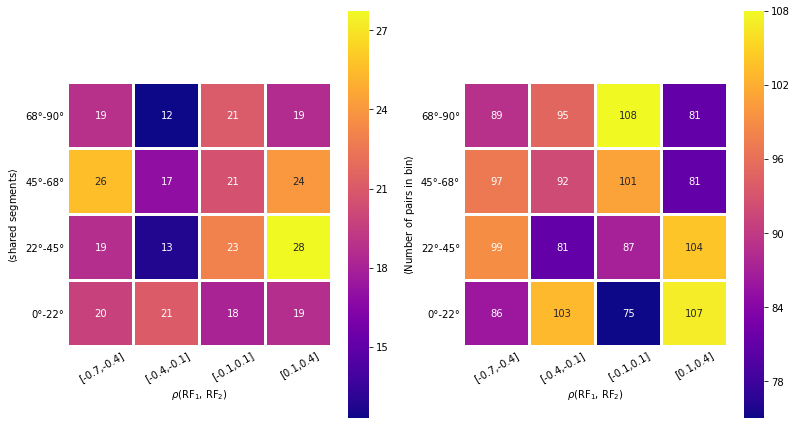

In [38]:
gs = plt.GridSpec(1,2)
fig = plt.figure(figsize=(13,7.5))
ax_heat_shared = fig.add_subplot(gs[0,0])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori_2', 'bcorr_2'])['n_seg_shared'].mean().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori_2', 'bcorr_2', 'n_seg_shared')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_shared)
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

ax_heat_count = fig.add_subplot(gs[0,1])

#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori_2', 'bcorr_2'])['n_seg_shared'].count().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori_2', 'bcorr_2', 'n_seg_shared')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_count,fmt='g')
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')



In [ ]:
[-0.45 -0.07  0.12  0.6 ] #don't use squares but use unequal rectangles 

In [ ]:
#groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].count().reset_index()
#turns the pairs into a pivot table that can be visualized as a heatmap
df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
#graphs the heat map
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2)
#applys the y labels for the shared segments (have to format it so they will show the degrees)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#sets the rf labels and rotates them slightly
g.set_xticklabels(cbin_labels, rotation=30)
#inverts the y axis so that they are going up in value as graph goes up
g.invert_yaxis()
#sets no tick marks
g.tick_params(length=0)
#set labels
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')


In [ ]:
"""
Pulls from the cdf table
Plots the binned difference in orientation (x) vs. average number of shared segments
makes the hue the binned correlation 

but does dso from the cdf so it has to perform the point calculation a nd includes a distribution bar



"""
g = sns.catplot('bdori', 'n_seg_shared', hue='bcorr', kind='bar', palette=sns.color_palette('GnBu', n_colors=5), data=cdf, legend=False)
g.add_legend(prop={'size':12})
g.set_axis_labels(x_var=r'$\Delta \theta$', y_var=r'$\langle$shared axons$\rangle$')
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
new_labels = cbin_labels
g._legend.set_title(r'$\rho$(RF$_1$, RF$_2$)')
for t, l in zip(g._legend.texts, new_labels): 
    t.set_text(l)

sns.despine()
g.fig.savefig('figures/corr_vs_shared_input_bar.png', dpi=200)
g.fig.savefig('figures/corr_vs_shared_input_bar.pdf')

# Exploring the receptive fields

In [ ]:
neg90 = cdf[(cdf.dori > 70/180*np.pi) & (cdf.rf_corr_coef > .40)]
neg90

# old Way

In [ ]:
#shows that for the old table there was multiple scans in these tables so eventually had to take the mean
# to average the scans together

In [ ]:
#shohws that these receptive fields are a little more complex
example_rf = (nda.RF() & 'segment_id=39500491')#.fetch('rf')
example_rf#[0].mean(axis=0).shape #in the older version had to do a mean across the axis to get the receptive field

In [ ]:
spattune.BestSTA.Map()
#gets the mean of the rf ofr 2 segments in each one
neg90 = [rf.mean(axis=0) for rf in (spattune.BestSTA.Map & 'segment_id in (648518346341417536, 648518346341410817)').fetch('sta')]
neg0 = [rf.mean(axis=0) for rf in (spattune.BestSTA.Map & 'segment_id in (648518346341410817, 648518346349511983)').fetch('sta')]
pos0 = [rf.mean(axis=0) for rf in (spattune.BestSTA.Map & 'segment_id in (648518346349499085, 648518346349513012)').fetch('sta')]
pos90 = [rf.mean(axis=0) for rf in (spattune.BestSTA.Map & 'segment_id in (648518346341400285, 648518346346301093)').fetch('sta')]


# new Way

In [ ]:
#this would return the two receptive fields
rf = (spattune.BestSTA.Map & "segment_id in (648518346341417536,648518346341410817)")#.fetch("sta")


In [ ]:
spattune.BestSTA.Map()
#gets the mean of the rf ofr 2 segments in each one
neg90 = [rf for rf in (spattune.BestSTA.Map & 'segment_id in (648518346341417536, 648518346341410817)').fetch('sta')]
neg0 = [rf for rf in (spattune.BestSTA.Map & 'segment_id in (648518346341410817, 648518346349511983)').fetch('sta')]
pos0 = [rf for rf in (spattune.BestSTA.Map & 'segment_id in (648518346349499085, 648518346349513012)').fetch('sta')]
pos90 = [rf for rf in (spattune.BestSTA.Map & 'segment_id in (648518346341400285, 648518346346301093)').fetch('sta')]


In [ ]:
"""
All i did for this one is comment out the rf = rf.mean() because the
receptive fields passed are already a 90x160 array
"""

from itertools import chain
gs = plt.GridSpec(4, 2) #specifies geometry of a grid that subplot can be placed on 
fig = plt.figure(figsize=(7,7.5)) #defines size of the figure
#ax_heat = fig.add_subplot(gs[:,1:3]) #blocks off the middle two columns for the heat map
with sns.axes_style('whitegrid'):
    ax_tl = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]
    ax_tr = [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]
    ax_br = [fig.add_subplot(gs[2,0]), fig.add_subplot(gs[2,1])]
    ax_bl = [fig.add_subplot(gs[3,0]), fig.add_subplot(gs[3,1])]
    
    
for tl, rf in chain(zip(ax_tl, neg90), zip(ax_bl, neg0), zip(ax_br, pos0),  zip(ax_tr, pos90)):
    print(rf.shape)
    #rf -= rf.mean()
    v = np.abs(rf).max()
#     tl.contour(rf, cmap='bwr', levels=np.linspace(-v,v,7))
    tl.matshow(rf, cmap='bwr', vmin=-v, vmax=v) #
    tl.set_xticklabels([])
    tl.set_yticklabels([])
    tl.tick_params(axis='both', length=0, width=0)


In [ ]:
"""
Conclusion: Easy Way to get the receptive fields:
Just use spattune.BestSTA.Map and it fill give you the 90x160 array and you can just plot that
- NO AVERAGEING THAT NEEDS TO BE DONE BECAUSE NEVER RETURNS MULTIPLE SCANS

"""